# Import Statements

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

In [3]:
data = pd.read_csv("D:\\FYP\\AzureDatasetPacking2019\\Aggregated Data\\aggregated_vmtable_correct_dates.csv")

In [4]:
data["index"] = pd.to_datetime(data["index"])
data = data.set_index("index")
data = data[["avg_cpu", "max_cpu", "p95_max_cpu", "vm_virtual_core_count", "vm_memory_gb"]]
data.drop(data.tail(1).index,inplace=True)

In [5]:
data.tail()

,avg_cpu,max_cpu,p95_max_cpu,vm_virtual_core_count,vm_memory_gb
index,,,,,
2016-12-15 23:30:00,626983.167079,4.479192e+06,2.226580e+06,130741,339591.25
2016-12-15 23:35:00,625220.260839,4.478651e+06,2.229860e+06,129979,337958.75
2016-12-15 23:40:00,622813.265551,4.468815e+06,2.223262e+06,129731,337061.75
2016-12-15 23:45:00,619207.294106,4.450889e+06,2.209649e+06,129230,336097.00
2016-12-15 23:50:00,615505.559907,4.433751e+06,2.196580e+06,128805,334848.25


# Detrend the data

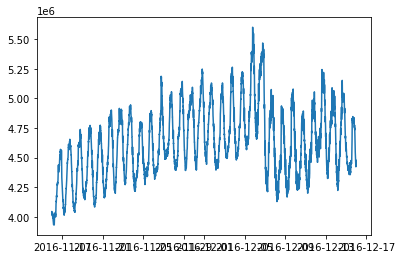

In [6]:
plt.plot(data["max_cpu"])
plt.show()

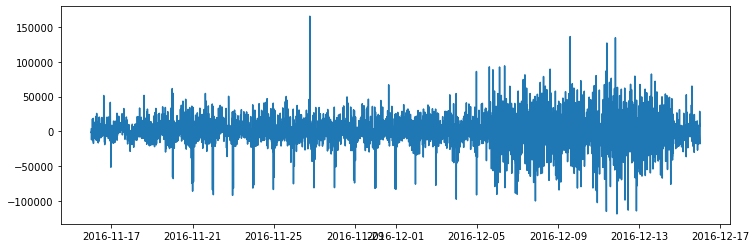

In [7]:
data = data.diff()
data = data.drop(data.head(1).index)

plt.figure(figsize=(12,4))
plt.plot(data["max_cpu"])
plt.show()

# Rolling Window DataFrame
## Window: 48 (4 hours), two step ahead
VM Table, Max. CPU

In [8]:
col_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14",
              "x15", "x16", "x17", "x18", "x19", "x20", "x21", "x22", "x23", "x24", "x25", "x26", "x27",
              "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40",
              "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [9]:
windows = 48

rw48_predictions = data.reset_index()

rw48_windows = pd.DataFrame([window.to_list() for window in data["max_cpu"].rolling(window=windows+1)], 
                          columns =  col_names + ["extra"])

rw48_predictions = pd.merge(rw48_predictions, rw48_windows, left_index=True, right_index=True)
           
rw48_predictions.head()

,index,avg_cpu,max_cpu,p95_max_cpu,vm_virtual_core_count,vm_memory_gb,x1,x2,x3,x4,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,extra
0,2016-11-16 00:05:00,944.249350,3279.578777,2063.958099,-45.0,-162.75,3279.578777,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-11-16 00:10:00,-669.229187,-2080.483273,-2537.347221,-196.0,-513.00,3279.578777,-2080.483273,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-11-16 00:15:00,-462.355911,-364.112724,-892.153017,-114.0,-245.50,3279.578777,-2080.483273,-364.112724,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-11-16 00:20:00,-1057.217552,-423.895115,-1225.400686,-137.0,-325.75,3279.578777,-2080.483273,-364.112724,-423.895115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-11-16 00:25:00,-4534.552752,-12107.873949,-11858.432480,-772.0,-1831.00,3279.578777,-2080.483273,-364.112724,-423.895115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
rw48_predictions = rw48_predictions.drop(rw48_predictions.head(windows+1).index) # drop first rows with NAN values

In [11]:
rw48_predictions = rw48_predictions[["index", "max_cpu"] + col_names]

In [12]:
train, test = train_test_split(rw48_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6871, 50), (1718, 50))

# Normalise the data

In [13]:
scaler = MinMaxScaler()
train[["max_cpu"] + col_names] = scaler.fit_transform(train[["max_cpu"] + col_names])
test[["max_cpu"] + col_names] = scaler.transform(test[["max_cpu"] + col_names])

In [14]:
norm_max_cpu = pd.concat([train, test])
norm_max_cpu.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Normalised Data/max_cpu_norm.csv")

In [15]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['max_cpu'].values, test_size=0.2, random_state=42, shuffle=False)

In [16]:
x_train = train[col_names]
y_train = train["max_cpu"]
x_test = test[col_names]
y_test = test["max_cpu"]

# Prediction Models
Use two step ahead prediction: t1-t5 predict t7
shift all current preds by -1 and delete last row
### Baseline

In [17]:
test["baseline"] = test[["max_cpu"]].shift(1) # for step ahead prediction
test = test.drop(test.head(1).index) # Drop first row as it has no baseline predictor
test.head()

,index,max_cpu,x1,x2,x3,x4,x5,x6,x7,x8,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,baseline
6921,2016-12-10 00:50:00,0.538668,0.363362,0.436075,0.488234,0.325469,0.229965,0.263806,0.224949,0.182934,...,0.378362,0.309618,0.407156,0.366925,0.381946,0.363166,0.351958,0.380509,0.500398,0.500398
6922,2016-12-10 00:55:00,0.481025,0.436075,0.488234,0.325469,0.229965,0.263806,0.224949,0.182934,0.200285,...,0.309618,0.407156,0.366925,0.381946,0.363166,0.351958,0.380509,0.500398,0.538668,0.538668
6923,2016-12-10 01:00:00,0.290013,0.488234,0.325469,0.229965,0.263806,0.224949,0.182934,0.200285,0.342839,...,0.407156,0.366925,0.381946,0.363166,0.351958,0.380509,0.500398,0.538668,0.481025,0.481025
6924,2016-12-10 01:05:00,0.258677,0.325469,0.229965,0.263806,0.224949,0.182934,0.200285,0.342839,0.381027,...,0.366925,0.381946,0.363166,0.351958,0.380509,0.500398,0.538668,0.481025,0.290013,0.290013
6925,2016-12-10 01:10:00,0.166981,0.229965,0.263806,0.224949,0.182934,0.200285,0.342839,0.381027,0.356177,...,0.381946,0.363166,0.351958,0.380509,0.500398,0.538668,0.481025,0.290013,0.258677,0.258677


### Linear Regression

In [18]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.25568397411052357


In [18]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

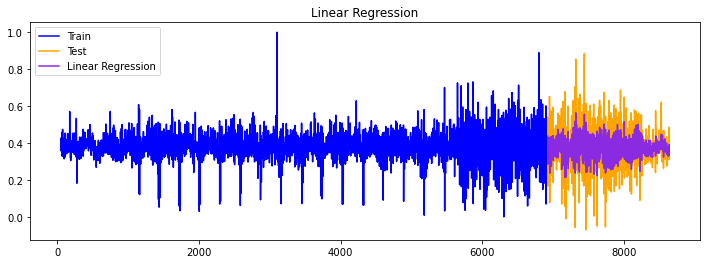

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [21]:
rw48_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["max_cpu"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['max_cpu'], test['baseline']))] })

In [22]:
lr_mape = mean_absolute_error(test["max_cpu"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw48_results = pd.concat([rw48_results, lr_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051430,0.074656


###  Decision Tree

In [23]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 3}
0.14172305154548198


In [29]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

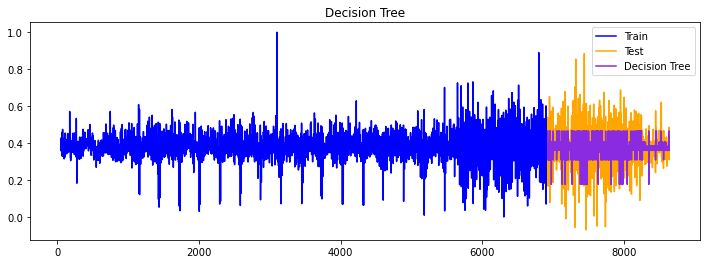

In [30]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [31]:
dt_mape = mean_absolute_error(test["max_cpu"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw48_results = pd.concat([rw48_results, dt_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051430,0.074656
0,Decision Tree,0.053808,0.079122


### Random Forest

In [24]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.23673332969680294


In [32]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

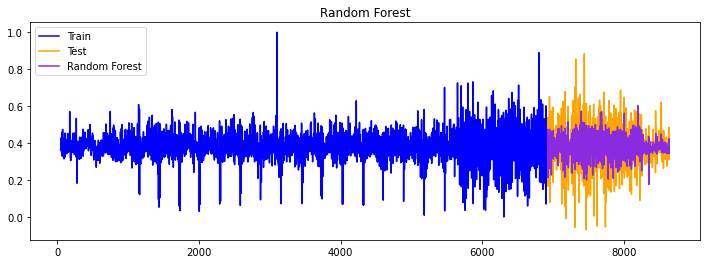

In [33]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [34]:
rf_mape = mean_absolute_error(test["max_cpu"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw48_results = pd.concat([rw48_results, rf_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051430,0.074656
0,Decision Tree,0.053808,0.079122
0,Random Forest,0.051324,0.074678


### Gradient Boosting

In [25]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 100}
0.22922293537143246


In [35]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=100, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

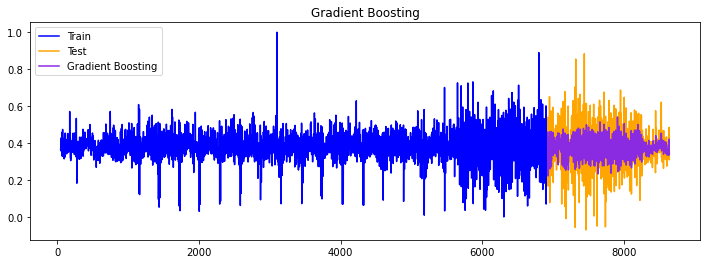

In [36]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [37]:
gb_mape = mean_absolute_error(test["max_cpu"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw48_results = pd.concat([rw48_results, gb_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051430,0.074656
0,Decision Tree,0.053808,0.079122
0,Random Forest,0.051324,0.074678
0,Gradient Boosting,0.050224,0.073591


### KNN

In [26]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
0.10919101423496269


In [38]:
knn_model = KNeighborsRegressor(algorithm='auto', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

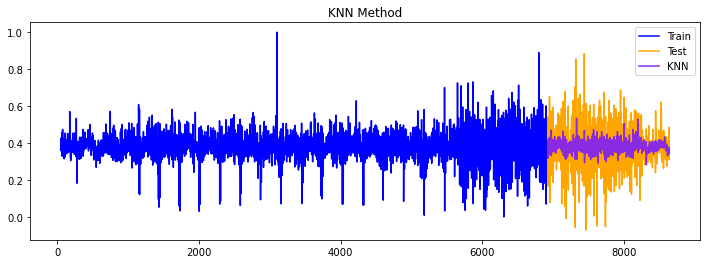

In [39]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [40]:
knn_mape = mean_absolute_error(test["max_cpu"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw48_results = pd.concat([rw48_results, knn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051430,0.074656
0,Decision Tree,0.053808,0.079122
0,Random Forest,0.051324,0.074678
0,Gradient Boosting,0.050224,0.073591
0,KNN,0.055000,0.080797


### Neural Network

In [27]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'tanh', 'hidden_layer_sizes': 150, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.2529253192192492


In [41]:
nn_model = MLPRegressor(random_state=1, activation='tanh', hidden_layer_sizes=150, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

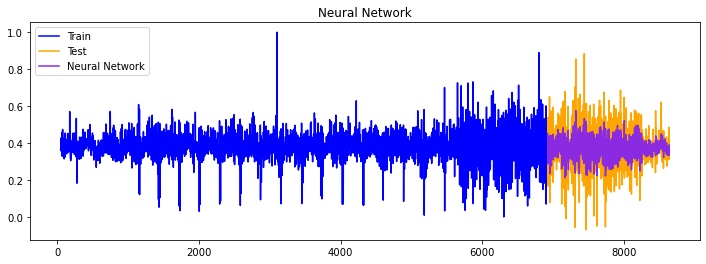

In [42]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [43]:
nn_mape = mean_absolute_error(test["max_cpu"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw48_results = pd.concat([rw48_results, nn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051430,0.074656
0,Decision Tree,0.053808,0.079122
0,Random Forest,0.051324,0.074678
0,Gradient Boosting,0.050224,0.073591
0,KNN,0.055000,0.080797
0,Neural Network,0.052172,0.075396


### Simple Moving Average

In [20]:
test["sma_pred"] = test[col_names].mean(axis=1)[1:] + [0]

In [21]:
test = test.drop(test.head(1).index) # Drop last row

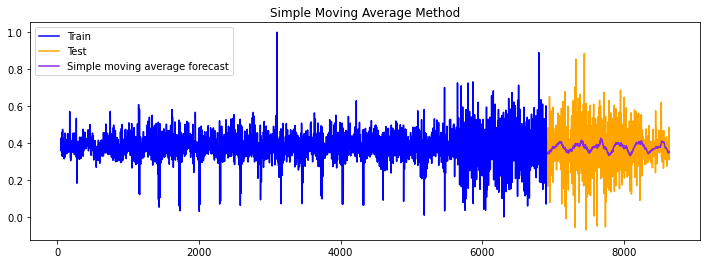

In [22]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

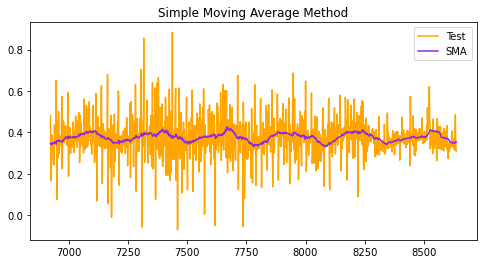

In [24]:
plt.figure(figsize=(8,4))
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='SMA', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [46]:
sma_mape = mean_absolute_error(test["max_cpu"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw48_results = pd.concat([rw48_results, sma_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051430,0.074656
0,Decision Tree,0.053808,0.079122
0,Random Forest,0.051324,0.074678
0,Gradient Boosting,0.050224,0.073591
0,KNN,0.055000,0.080797
0,Neural Network,0.052172,0.075396
0,Simple Moving Avg.,0.056306,0.084234


## Window: 24 (2 hours)

In [13]:
window = 24

rw24_predictions = rw48_predictions[["index", "max_cpu", "x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32",
                                    "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw24_predictions.head()

,index,max_cpu,x25,x26,x27,x28,x29,x30,x31,x32,...,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,-2561.081476,-6600.834033,-13594.100885,2878.681549,1970.000603,18711.557013,8230.719401,-17328.230630,-3481.074251,...,-4749.548777,-5027.441929,-814.784416,914.792316,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229
50,2016-11-16 04:15:00,-1569.844381,-13594.100885,2878.681549,1970.000603,18711.557013,8230.719401,-17328.230630,-3481.074251,-3884.596091,...,-5027.441929,-814.784416,914.792316,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229,-2561.081476
51,2016-11-16 04:20:00,-2710.315285,2878.681549,1970.000603,18711.557013,8230.719401,-17328.230630,-3481.074251,-3884.596091,881.087273,...,-814.784416,914.792316,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229,-2561.081476,-1569.844381
52,2016-11-16 04:25:00,255.537140,1970.000603,18711.557013,8230.719401,-17328.230630,-3481.074251,-3884.596091,881.087273,-10620.917947,...,914.792316,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229,-2561.081476,-1569.844381,-2710.315285
53,2016-11-16 04:30:00,13346.759654,18711.557013,8230.719401,-17328.230630,-3481.074251,-3884.596091,881.087273,-10620.917947,-1561.989277,...,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229,-2561.081476,-1569.844381,-2710.315285,255.537140


In [14]:
train, test = train_test_split(rw24_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6871, 26), (1718, 26))

# Normalise the data

In [49]:
col_names = ["x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40","x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [50]:
scaler = MinMaxScaler()
train[["max_cpu"] + col_names] = scaler.fit_transform(train[["max_cpu"] + col_names])
test[["max_cpu"] + col_names] = scaler.transform(test[["max_cpu"] + col_names])

In [51]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['max_cpu'].values, test_size=0.2, random_state=42, shuffle=False)

In [52]:
x_train = train[col_names]
y_train = train["max_cpu"]
x_test = test[col_names]
y_test = test["max_cpu"]

# Prediction Models
Use two step ahead prediction: t1-t5 predict t7
shift all current preds by -1 and delete last row
### Baseline

In [53]:
test["baseline"] = test[["max_cpu"]].shift(1)
test = test.drop(test.head(1).index)
test.head()

,index,max_cpu,x25,x26,x27,x28,x29,x30,x31,x32,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,baseline
6921,2016-12-10 00:50:00,0.538668,0.601250,0.069780,0.309105,0.224161,0.178077,0.330812,0.406818,0.350048,...,0.378362,0.309618,0.407156,0.366925,0.381946,0.363166,0.351958,0.380509,0.500398,0.500398
6922,2016-12-10 00:55:00,0.481025,0.069780,0.309105,0.224161,0.178077,0.330812,0.406818,0.350048,0.276125,...,0.309618,0.407156,0.366925,0.381946,0.363166,0.351958,0.380509,0.500398,0.538668,0.538668
6923,2016-12-10 01:00:00,0.290013,0.309105,0.224161,0.178077,0.330812,0.406818,0.350048,0.276125,0.369952,...,0.407156,0.366925,0.381946,0.363166,0.351958,0.380509,0.500398,0.538668,0.481025,0.481025
6924,2016-12-10 01:05:00,0.258677,0.224161,0.178077,0.330812,0.406818,0.350048,0.276125,0.369952,0.329930,...,0.366925,0.381946,0.363166,0.351958,0.380509,0.500398,0.538668,0.481025,0.290013,0.290013
6925,2016-12-10 01:10:00,0.166981,0.178077,0.330812,0.406818,0.350048,0.276125,0.369952,0.329930,0.373479,...,0.381946,0.363166,0.351958,0.380509,0.500398,0.538668,0.481025,0.290013,0.258677,0.258677


### Linear Regression

In [54]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.2424810712936576


In [55]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

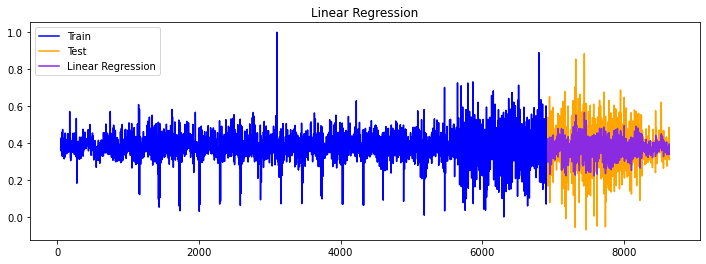

In [56]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [57]:
rw24_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["max_cpu"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['max_cpu'], test['baseline']))] })

In [58]:
lr_mape = mean_absolute_error(test["max_cpu"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw24_results = pd.concat([rw24_results, lr_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051577,0.075455


### Decision Tree

In [59]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 3}
0.144230022085796


In [65]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

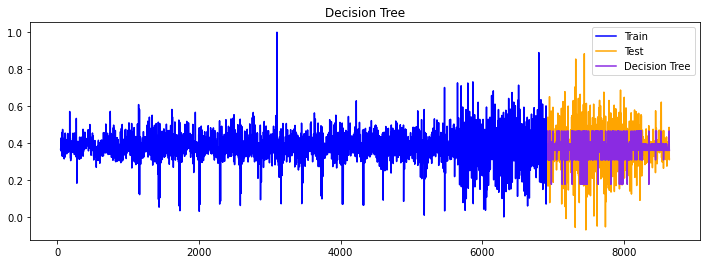

In [66]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [67]:
dt_mape = mean_absolute_error(test["max_cpu"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw24_results = pd.concat([rw24_results, dt_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051577,0.075455
0,Decision Tree,0.053538,0.079006


### Random Forest

In [60]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.23218955930934337


In [68]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

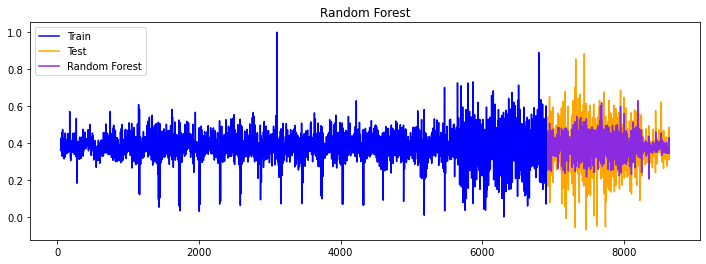

In [69]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [70]:
rf_mape = mean_absolute_error(test["max_cpu"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw24_results = pd.concat([rw24_results, rf_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051577,0.075455
0,Decision Tree,0.053538,0.079006
0,Random Forest,0.051171,0.074527


### Gradient Boosting

In [61]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 100}
0.21530411290937895


In [71]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=100, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

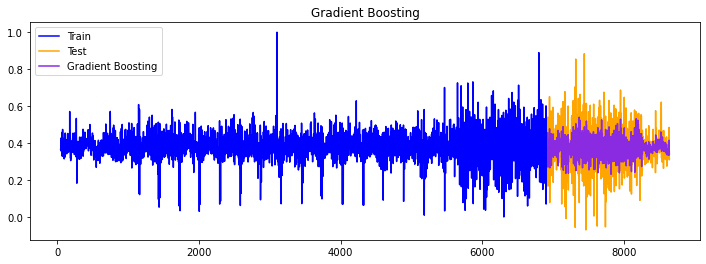

In [72]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [73]:
gb_mape = mean_absolute_error(test["max_cpu"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw24_results = pd.concat([rw24_results, gb_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051577,0.075455
0,Decision Tree,0.053538,0.079006
0,Random Forest,0.051171,0.074527
0,Gradient Boosting,0.050365,0.073941


### KNN

In [62]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}
0.14128952651661847


In [74]:
knn_model = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

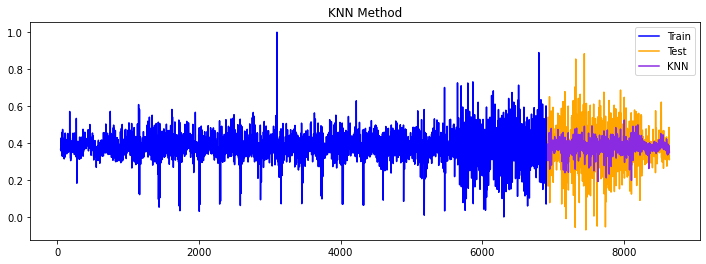

In [75]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [76]:
knn_mape = mean_absolute_error(test["max_cpu"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw24_results = pd.concat([rw24_results, knn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051577,0.075455
0,Decision Tree,0.053538,0.079006
0,Random Forest,0.051171,0.074527
0,Gradient Boosting,0.050365,0.073941
0,KNN,0.055265,0.080109


### Neural Network

In [63]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'identity', 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.2439361140210331


In [77]:
nn_model = MLPRegressor(random_state=1, activation='identity', hidden_layer_sizes=200, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

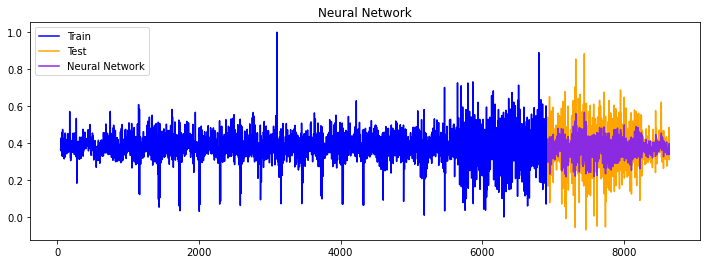

In [78]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [79]:
nn_mape = mean_absolute_error(test["max_cpu"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw24_results = pd.concat([rw24_results, nn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051577,0.075455
0,Decision Tree,0.053538,0.079006
0,Random Forest,0.051171,0.074527
0,Gradient Boosting,0.050365,0.073941
0,KNN,0.055265,0.080109
0,Neural Network,0.051612,0.075450


### Simple Moving Average

In [64]:
test["sma_pred"] = test[col_names].mean(axis=1)[1:] + [0]

In [80]:
test = test.drop(test.head(1).index)

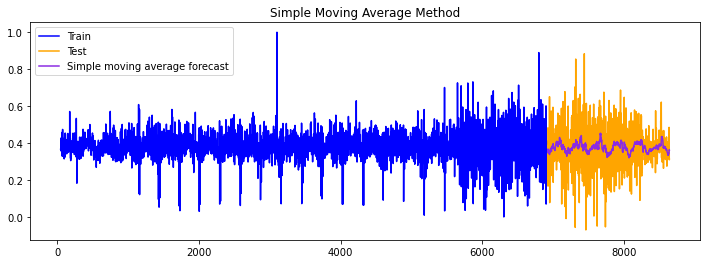

In [81]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [82]:
sma_mape = mean_absolute_error(test["max_cpu"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw24_results = pd.concat([rw24_results, sma_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.051577,0.075455
0,Decision Tree,0.053538,0.079006
0,Random Forest,0.051171,0.074527
0,Gradient Boosting,0.050365,0.073941
0,KNN,0.055265,0.080109
0,Neural Network,0.051612,0.075450
0,Simple Moving Avg.,0.056057,0.084420


## Window: 12 (1 hour)

In [83]:
col_names = ["x37", "x38", "x39", "x40", "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [84]:
window = 12

rw12_predictions = rw48_predictions[["index", "max_cpu", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw12_predictions.head()

,index,max_cpu,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,-2561.081476,-8588.818227,-7643.951815,-4749.548777,-5027.441929,-814.784416,914.792316,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229
50,2016-11-16 04:15:00,-1569.844381,-7643.951815,-4749.548777,-5027.441929,-814.784416,914.792316,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229,-2561.081476
51,2016-11-16 04:20:00,-2710.315285,-4749.548777,-5027.441929,-814.784416,914.792316,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229,-2561.081476,-1569.844381
52,2016-11-16 04:25:00,255.537140,-5027.441929,-814.784416,914.792316,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229,-2561.081476,-1569.844381,-2710.315285
53,2016-11-16 04:30:00,13346.759654,-814.784416,914.792316,-3846.020867,-2502.722985,-389.225312,-6006.391240,-6398.442864,-259.397229,-2561.081476,-1569.844381,-2710.315285,255.537140


In [85]:
train, test = train_test_split(rw12_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6871, 14), (1718, 14))

# Normalise the data

In [86]:
scaler = MinMaxScaler()
train[["max_cpu"] + col_names] = scaler.fit_transform(train[["max_cpu"] + col_names])
test[["max_cpu"] + col_names] = scaler.transform(test[["max_cpu"] + col_names])

In [87]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['max_cpu'].values, test_size=0.2, random_state=42, shuffle=False)

In [88]:
x_train = train[col_names]
y_train = train["max_cpu"]
x_test = test[col_names]
y_test = test["max_cpu"]

# Prediction Models
Use two step ahead prediction: t1-t5 predict t7
shift all current preds by -1 and delete last row
### Baseline

In [89]:
test["baseline"] = test[["max_cpu"]].shift(1) # for step ahead prediction
test = test.drop(test.head(1).index) # Drop first row as it has no baseline predictor

### Linear Regression

In [90]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.19882010575791426


In [91]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

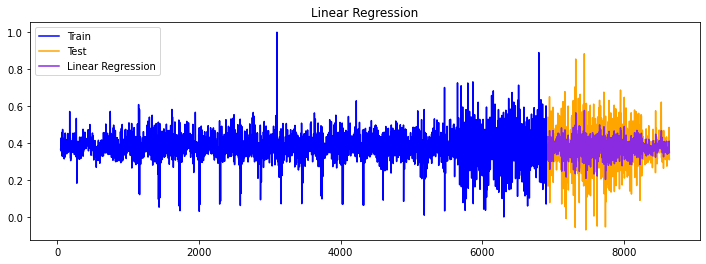

In [92]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [93]:
rw12_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["max_cpu"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['max_cpu'], test['baseline']))] })

In [94]:
lr_mape = mean_absolute_error(test["max_cpu"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw12_results = pd.concat([rw12_results, lr_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.052730,0.077537


### Decision Tree

In [95]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 3}
0.15984014364285165


In [101]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

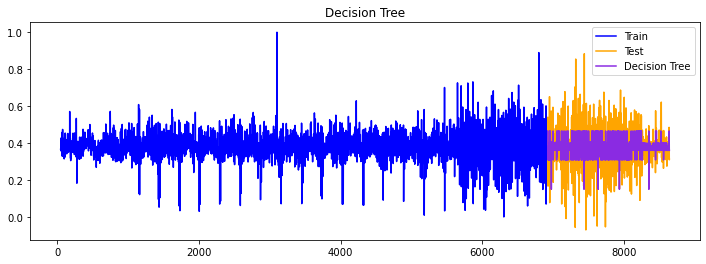

In [102]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [103]:
dt_mape = mean_absolute_error(test["max_cpu"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw12_results = pd.concat([rw12_results, dt_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.052730,0.077537
0,Decision Tree,0.053489,0.079020


### Random Forest

In [96]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 5}
0.222910829466892


In [104]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth= 5)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

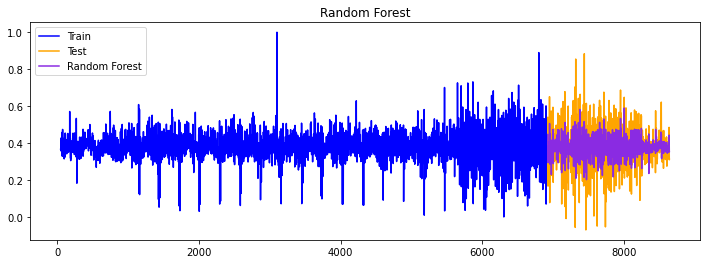

In [105]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [106]:
rf_mape = mean_absolute_error(test["max_cpu"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw12_results = pd.concat([rw12_results, rf_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.052730,0.077537
0,Decision Tree,0.053489,0.079020
0,Random Forest,0.052429,0.076780


### Gradient Boosting

In [97]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 100}
0.19048297711833756


In [107]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=100, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

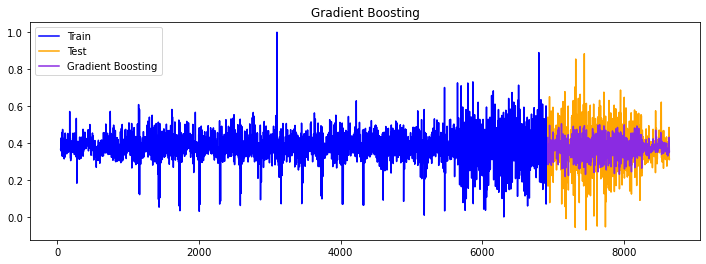

In [108]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [109]:
gb_mape = mean_absolute_error(test["max_cpu"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw12_results = pd.concat([rw12_results, gb_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.052730,0.077537
0,Decision Tree,0.053489,0.079020
0,Random Forest,0.052429,0.076780
0,Gradient Boosting,0.051987,0.076312


### KNN

In [98]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'distance'}
0.14012072104377493


In [110]:
knn_model = KNeighborsRegressor(algorithm='brute', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

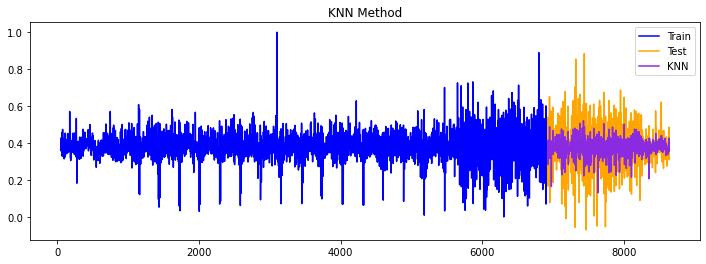

In [111]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [112]:
knn_mape = mean_absolute_error(test["max_cpu"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw12_results = pd.concat([rw12_results, knn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.052730,0.077537
0,Decision Tree,0.053489,0.079020
0,Random Forest,0.052429,0.076780
0,Gradient Boosting,0.051987,0.076312
0,KNN,0.054886,0.079933


### Neural Network

In [99]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'identity', 'hidden_layer_sizes': 150, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.2007134121342518


In [113]:
nn_model = MLPRegressor(random_state=1, activation='identity', hidden_layer_sizes=150, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

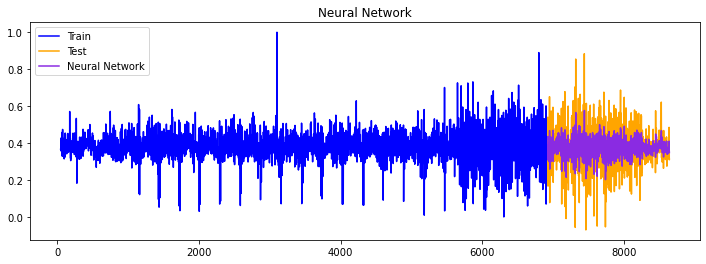

In [114]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [115]:
nn_mape = mean_absolute_error(test["max_cpu"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw12_results = pd.concat([rw12_results, nn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.052730,0.077537
0,Decision Tree,0.053489,0.079020
0,Random Forest,0.052429,0.076780
0,Gradient Boosting,0.051987,0.076312
0,KNN,0.054886,0.079933
0,Neural Network,0.052780,0.077568


### Simple Moving Average

In [100]:
test["sma_pred"] = test[col_names].mean(axis=1)[1:]+[0]

In [116]:
test = test.drop(test.head(1).index) # Drop last row

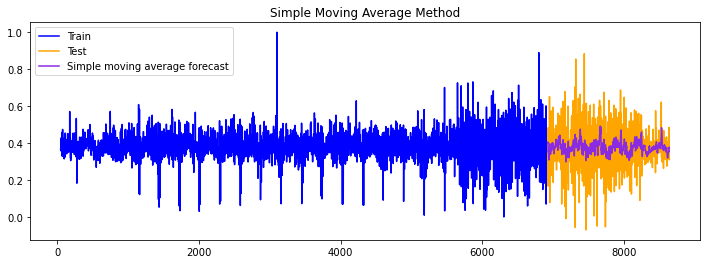

In [117]:
plt.figure(figsize=(12,4))
plt.plot(train['max_cpu'], label='Train', color="b")
plt.plot(test['max_cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [118]:
sma_mape = mean_absolute_error(test["max_cpu"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['max_cpu'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw12_results = pd.concat([rw12_results, sma_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.065512,0.094734
0,Linear Regression,0.052730,0.077537
0,Decision Tree,0.053489,0.079020
0,Random Forest,0.052429,0.076780
0,Gradient Boosting,0.051987,0.076312
0,KNN,0.054886,0.079933
0,Neural Network,0.052780,0.077568
0,Simple Moving Avg.,0.057976,0.086880


# Result Comparision

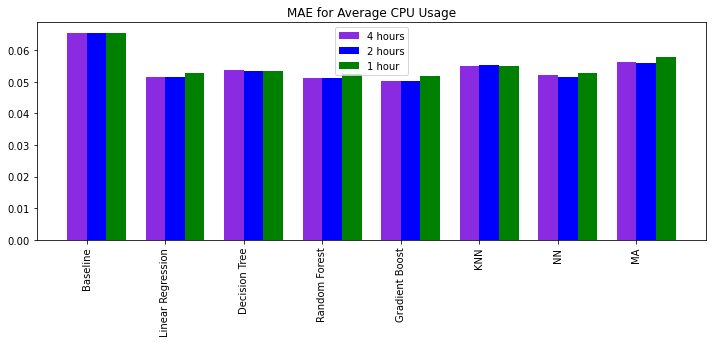

In [119]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["MAE"], width=width, label="4 hours", color="blueviolet")
plt.bar(r+width, rw24_results["MAE"], width=width, label="2 hours", color="b")
plt.bar(r+width+width, rw12_results["MAE"], width=width, label="1 hour", color="g")
plt.legend()
plt.title("MAE for Average CPU Usage")
plt.xticks(r + width/2,['Baseline', 'Linear Regression','Decision Tree','Random Forest','Gradient Boost', 'KNN','NN', 'MA'], rotation=90)
plt.show()

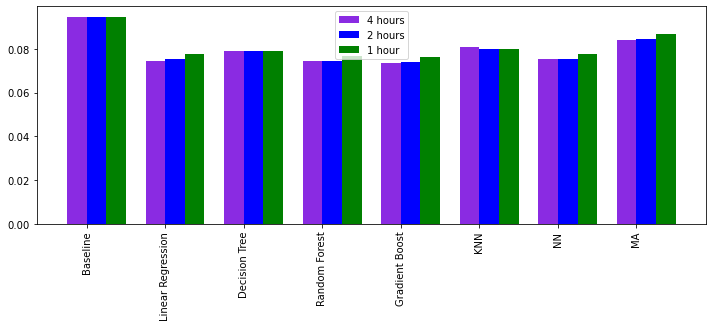

In [120]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["RMSE"], width=width, label="4 hours", color="blueviolet")
plt.bar(r+width, rw24_results["RMSE"], width=width, label="2 hours", color="b")
plt.bar(r+width+width, rw12_results["RMSE"], width=width, label="1 hour", color="g")
plt.legend()
plt.xticks(r + width/2,['Baseline', 'Linear Regression','Decision Tree','Random Forest','Gradient Boost', 'KNN', 'NN', 'MA'], rotation=90)
plt.show()

In [121]:
rw48_results = rw48_results.reset_index()
rw24_results = rw24_results.reset_index()
rw12_results = rw12_results.reset_index()

In [122]:
total_results = pd.merge(rw48_results, rw24_results, on='Method', how='outer')
total_results = pd.merge(total_results, rw12_results, on='Method', how='outer')
total_results.head()

,index_x,Method,MAE_x,RMSE_x,index_y,MAE_y,RMSE_y,index,MAE,RMSE
0,0,Baseline,0.065512,0.094734,0,0.065512,0.094734,0,0.065512,0.094734
1,0,Linear Regression,0.051430,0.074656,0,0.051577,0.075455,0,0.052730,0.077537
2,0,Decision Tree,0.053808,0.079122,0,0.053538,0.079006,0,0.053489,0.079020
3,0,Random Forest,0.051324,0.074678,0,0.051171,0.074527,0,0.052429,0.076780
4,0,Gradient Boosting,0.050224,0.073591,0,0.050365,0.073941,0,0.051987,0.076312


In [123]:
total_results = total_results[["Method","MAE_x", "RMSE_x", "MAE_y", "RMSE_y", "MAE", "RMSE"]]

In [124]:
 total_results = total_results.rename(columns={total_results.columns[0]: "Methods", 
                              total_results.columns[1]: "MAE (w=48)", total_results.columns[2]: "RMSE (w=48)", 
                              total_results.columns[3]: "MAE (w=24)", total_results.columns[4]: "RMSE (w=24)", 
                              total_results.columns[5]: "MAE (w=12)", total_results.columns[6]: "RMSE (w=12)", 
                            })

In [125]:
total_results.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Results/max_cpu_results.csv")

In [32]:
rw_tests = test
rw_tests["SMA_24"] = rw_tests[["x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40","x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]].mean(axis=1)[1:] + [0]
rw_tests["SMA_12"] = rw_tests[["x37", "x38", "x39", "x40","x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]].mean(axis=1)[1:] + [0]

In [33]:
rw_tests = rw_tests.drop(rw_tests.head(1).index) # Drop last row

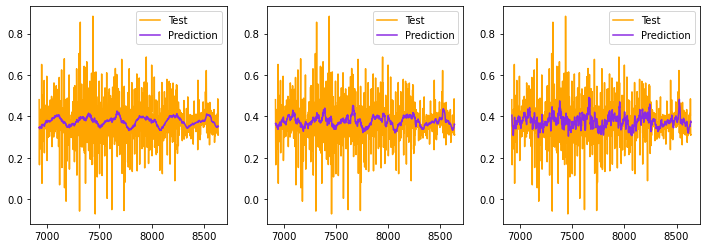

In [39]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(12,4))
ax1.plot(test['max_cpu'], label='Test', color="orange")
ax1.plot(test['sma_pred'], label='Prediction', color="blueviolet")
ax1.legend(loc='best')

ax2.plot(test['max_cpu'], label='Test', color="orange")
ax2.plot(rw_tests['SMA_24'], label='Prediction', color="blueviolet")
ax2.legend(loc='best')

ax3.plot(test['max_cpu'], label='Test', color="orange")
ax3.plot(rw_tests['SMA_12'], label='Prediction', color="blueviolet")
ax3.legend(loc='best')
plt.show()